# SLAM Unit G
This unit is about the particle filter SLAM.

## The Rao-Blackwellized particle filter
We first recap a few of our earlier results: the particle filter (for localization only) and the extended Kalman filter (EKF) SLAM (for localization *and* mapping). Starting from there, we think about how a particle filter SLAM would look like and introduce a special way to realize it, named the Rao-Blackwellized particle filter.

In [164]:
# If you don't see a video below, run this cell.
# YouTube = True  # Uncomment to get YouTube videos instead of TIB AV.
from IPython.display import IFrame
IFrame("https://www.youtube.com/embed/9WyrWJcvneE" if "YouTube" in globals() else "//av.tib.eu/player/49032",
       width=560, height=315)

### A first question (2 Points).
I have to admit there is a bug in the video. If you have a normal distributed random variable $X$, then the probability for $X$ being between $\mu-\sigma$ and $\mu+\sigma$ is 0.68 (the number stated in the video). However, if $X$ is a multivariate distribution, the probability for being inside the "one-sigma error ellipsoid" will be smaller. For example, in our case $X=(x, y, \theta)\in\mathbb{R}^3$, so $X$ is a three-dimensional (multivariate) random variable. For simplicity, assume the covariance matrix to be the identity matrix, so the error ellipsoid would be a ball of radius 1. Can you figure out what the probability is for $X$ being inside this ball? (Hint: *Inside the ball* means $x^2 + y^2 + \theta^2 \leq 1$, so you could define $Y=x^2 + y^2 + \theta^2$ and determine the probability $\mbox{Pr}(Y\leq 1)$.)

In [165]:
# What is the probability for X being inside a ball of radius 1, when X is a
# 3D standard normal distributed variable? Give it as an integer percentage (rounded to the nearest integer).
percentage_inside_ball = 20  # That would be true for 1D, replace by your guess for the 3D case.
# YOUR CODE HERE


In [166]:
from hashlib import shake_128
def public_string_test(the_answer_string, reference):
    m = shake_128()
    m.update(the_answer_string.encode())
    return m.hexdigest(4) == reference
assert public_string_test(("percentage=%d" % percentage_inside_ball), '437038cf'), "Oh no, your answer is wrong!"

### A second question (2 Points).
What is the *space* complexity of the EKF SLAM and the presented Particle Filter (PF) SLAM with respect to the number of landmarks $N$?
- A: Both are linear in $N$
- B: Both are quadratic in $N$
- C: EKF is quadratic, PF is linear in $N$
- D: EKF is linear, PF is quadratic in $N$.

In [167]:
the_space_complexity_is = "C"  # Replace by your answer.
# YOUR CODE HERE


In [168]:
from hashlib import shake_128
def public_string_test(the_answer_string, reference):
    m = shake_128()
    m.update(the_answer_string.encode())
    return m.hexdigest(4) == reference
assert public_string_test("cplx="+the_space_complexity_is.strip().lower(), '7debab5a'), "Oh no, your answer is wrong!"

## Computing the correspondence likelihood

In [169]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/HfBqPi-ydrc" if "YouTube" in globals() else "//av.tib.eu/player/49033",
       width=560, height=315)

### The particle class.
First, we define a class that represents a single particle. Our filter (defined below) will have many particles to represent the belief. Using a class for the particle makes sense since, as we will learn, there is quite some data and functionality associated with a single particle.

In the beginning, however, our particle has only $(x,y,\theta)$ as member variables, and the only functionality (member functions) are the state transition `g()` (which we know from earlier units) and a `move()` function which simply applies `g()` to itself.

In [170]:
# FastSLAM, first version: prediciton only.
#
# slam_10_a_prediction
from lego_robot import *
from slam_g_library import get_mean, get_error_ellipse_and_heading_variance,\
     print_particles
from math import sin, cos, atan2, exp, pi, sqrt
import random
import numpy as np

class Particle_1:
    def __init__(self, pose):
        self.pose = pose

    @staticmethod
    def g(state, control, w):
        """State transition. This is exactly the same method as in the Kalman
           filter."""
        x, y, theta = state
        l, r = control
        if r != l:
            alpha = (r - l) / w
            rad = l/alpha
            g1 = x + (rad + w/2.)*(sin(theta+alpha) - sin(theta))
            g2 = y + (rad + w/2.)*(-cos(theta+alpha) + cos(theta))
            g3 = (theta + alpha + pi) % (2*pi) - pi
        else:
            g1 = x + l * cos(theta)
            g2 = y + l * sin(theta)
            g3 = theta
        return np.array([g1, g2, g3])

    def move(self, left, right, w):
        """Given left, right control and robot width, move the robot."""
        self.pose = self.g(self.pose, (left, right), w)

### The particle filter class.
We call this class `FastSLAM`. So far, we only implement the prediction step. This is identical to the prediction step we had earlier in Unit E.

In [171]:
class FastSLAM_1:
    def __init__(self, initial_particles,
                 robot_width, scanner_displacement,
                 control_motion_factor, control_turn_factor):
        # The particles.
        self.particles = initial_particles

        # Some constants.
        self.robot_width = robot_width
        self.scanner_displacement = scanner_displacement
        self.control_motion_factor = control_motion_factor
        self.control_turn_factor = control_turn_factor

    def predict(self, control):
        """The prediction step of the particle filter."""
        left, right = control
        left_std  = sqrt((self.control_motion_factor * left)**2 +\
                        (self.control_turn_factor * (left-right))**2)
        right_std = sqrt((self.control_motion_factor * right)**2 +\
                         (self.control_turn_factor * (left-right))**2)
        # Modify list of particles: for each particle, predict its new position.
        for p in self.particles:
            l = random.gauss(left, left_std)
            r = random.gauss(right, right_std)
            p.move(l, r, self.robot_width)

### The main function.
Here is the remaining main function. Run it to produce the results from the video.

In [172]:
if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.

    # Generate initial particles. Each particle is (x, y, theta).
    number_of_particles = 25
    start_state = np.array([500.0, 0.0, 45.0 / 180.0 * pi])
    initial_particles = [Particle_1(start_state.copy())
                         for _ in range(number_of_particles)]

    # Setup filter.
    fs = FastSLAM_1(initial_particles,
                    robot_width, scanner_displacement,
                    control_motion_factor, control_turn_factor)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")

    # Loop over all motor tick records.
    # This is the FastSLAM filter loop, prediction only.
    f = open("fast_slam_prediction.txt", "w")
    for i in range(len(logfile.motor_ticks)):
        # Prediction.
        control = [x * ticks_to_mm for x in logfile.motor_ticks[i]]
        fs.predict(control)

        # Output particles.
        print_particles(fs.particles, f)

        # Output state estimated from all particles.
        mean = get_mean(fs.particles)
        print("F %.0f %.0f %.3f" %\
              (mean[0] + scanner_displacement * cos(mean[2]),
               mean[1] + scanner_displacement * sin(mean[2]),
               mean[2]), file=f)

        # Output error ellipse and standard deviation of heading.
        errors = get_error_ellipse_and_heading_variance(fs.particles, mean)
        print("E %.3f %.0f %.0f %.3f" % errors, file=f)

    f.close()

### Let's have a look at the prediction.
As there is no landmark handling so far, there is no correction, and the result is the same as the prediction-only solution of Unit E.

You may run the following cell to compare with the results in the video. Note that each time you run the cell above (main), you will get a different result, because of the random sampling going on in `FastSLAM_1.predict()`. So it may fit more or less to the results shown in the video.

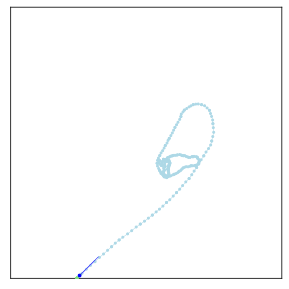

In [173]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["fast_slam_prediction.txt"])

### Programming assignment: compute the correspondence likelihood (10 Points).
Now we move on to the parts you'll have to program.

In the following cell, you will have to implement the functions `h_expected_measurement_for_landmark`, `H_Ql_jacobian_and_measurement_covariance_for_landmark`, and `wl_likelihood_of_correspondence`, as indicated. Note each of those is only very few lines of code, as explained in the above video.

In [174]:
# slam_10_b_correspondence_likelihood
class Particle_2(Particle_1):
    def __init__(self, pose):
        super().__init__(pose)
        self.landmark_positions = []
        self.landmark_covariances = []

    def number_of_landmarks(self):
        """Utility: return current number of landmarks in this particle."""
        return len(self.landmark_positions)

    @staticmethod
    def h(state, landmark, scanner_displacement):
        """Measurement function. Takes a (x, y, theta) state and a (x, y)
           landmark, and returns the corresponding (range, bearing)."""
        dx = landmark[0] - (state[0] + scanner_displacement * cos(state[2]))
        dy = landmark[1] - (state[1] + scanner_displacement * sin(state[2]))
        r = sqrt(dx * dx + dy * dy)
        alpha = (atan2(dy, dx) - state[2] + pi) % (2*pi) - pi
        return np.array([r, alpha])

    @staticmethod
    def dh_dlandmark(state, landmark, scanner_displacement):
        """Derivative with respect to the landmark coordinates. This is related
           to the dh_dstate function we used earlier (it is:
           -dh_dstate[0:2,0:2])."""
        theta = state[2]
        cost, sint = cos(theta), sin(theta)
        dx = landmark[0] - (state[0] + scanner_displacement * cost)
        dy = landmark[1] - (state[1] + scanner_displacement * sint)
        q = dx * dx + dy * dy
        sqrtq = sqrt(q)
        dr_dmx = dx / sqrtq
        dr_dmy = dy / sqrtq
        dalpha_dmx = -dy / q
        dalpha_dmy =  dx / q

        return np.array([[dr_dmx, dr_dmy],
                         [dalpha_dmx, dalpha_dmy]])

    def h_expected_measurement_for_landmark(self, landmark_number,
                                            scanner_displacement):
        """Returns the expected distance and bearing measurement for a given
           landmark number and the pose of this particle."""
        # Note: This is just one line of code!
        # Hints:
        # - the static function h() computes the desired value
        # - the state is the robot's pose
        # - the landmark is taken from self.landmark_positions.
        # YOUR CODE HERE

        return self.h(self.pose,self.landmark_positions[landmark_number], scanner_displacement)

    def H_Ql_jacobian_and_measurement_covariance_for_landmark(
        self, landmark_number, Qt_measurement_covariance, scanner_displacement):
        """Computes Jacobian H of measurement function at the particle's
           position and the landmark given by landmark_number. Also computes the
           measurement covariance matrix."""
        # Hints:
        # - H is computed using dh_dlandmark.
        # - To compute Ql, you will need the product of two matrices,
        #   which is A @ B (or alternatively, np.dot(A, B)).
#         H = np.eye(2)  # Replace this.
#         Ql = np.eye(2)  # Replace this.
        # YOUR CODE HERE
        H = self.dh_dlandmark(self.pose,self.landmark_positions[landmark_number], scanner_displacement)
        Sigma_k = self.landmark_covariances[landmark_number]
        Ql = np.dot(H, np.dot(Sigma_k,H.T)) + Qt_measurement_covariance
        return (H, Ql)

    def wl_likelihood_of_correspondence(self, measurement,
                                        landmark_number,
                                        Qt_measurement_covariance,
                                        scanner_displacement):
        """For a given measurement and landmark_number, returns the likelihood
           that the measurement corresponds to the landmark."""
        # Hints:
        # - You will need delta_z, which is the measurement minus the
        #   expected_measurement_for_landmark()
        
        delta_z = measurement - self.h_expected_measurement_for_landmark( landmark_number, scanner_displacement )
        delta_z[1] = (delta_z[1]+np.pi) % (2*np.pi) - np.pi
   
        # - IMPORTANT: Correct the angle component of delta_z to prevent
        #   multiples of 2 pi! Use something like:
        #   delta_z[1] = (delta_z[1]+np.pi) % (2*np.pi) - np.pi
        # - Ql is obtained using a call to
        #   H_Ql_jacobian_and_measurement_covariance_for_landmark(). You
        #   will only need Ql, not H
        
        H,Ql = self.H_Ql_jacobian_and_measurement_covariance_for_landmark( landmark_number,Qt_measurement_covariance,scanner_displacement )

        
        # - np.linalg.det(A) computes the determinant of A
        # - np.linalg.inv(A) computes the inverse of A.
        # YOUR CODE HERE
        
        detQl = np.linalg.det(Ql)
        e_factor = -0.5 * np.dot(delta_z.T, np.dot(np.linalg.inv(Ql),delta_z ))
        l = exp(e_factor)/(2*pi*sqrt(detQl))

        return l


        
    def compute_correspondence_likelihoods(self, measurement,
                                           number_of_landmarks,
                                           Qt_measurement_covariance,
                                           scanner_displacement):
        """For a given measurement, returns a list of all correspondence
           likelihoods (from index 0 to number_of_landmarks-1)."""
        likelihoods = []
        for i in range(number_of_landmarks):
            likelihoods.append(
                self.wl_likelihood_of_correspondence(
                    measurement, i, Qt_measurement_covariance,
                    scanner_displacement))
        return likelihoods

Run the following cell and compare the output to the one shown in the video.

In [175]:
def add_landmarks(particle):
    """Helper function to add some landmarks and their covariances."""
    # Add a landmark, at (500,-500), with standard deviation 100.
    particle.landmark_positions.append(np.array([500.0, -500.0]))
    particle.landmark_covariances.append(np.array(
        [[ 100.0**2,   0.0 ],
         [   0.0, 100.0**2 ]]))
    # Add two landmarks along the x axis, at 1000 and 2000, with
    # different covariances.
    particle.landmark_positions.append(np.array([1000.0, 0.0]))
    particle.landmark_covariances.append(np.array(
        [[ 100.0**2,   0.0 ],
         [   0.0, 100.0**2 ]]))
    particle.landmark_positions.append(np.array([2000.0, 0.0]))
    particle.landmark_covariances.append(np.array(
        [[ 200.0**2, -100.0**2 ],
         [-100.0**2,  200.0**2 ]]))

if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0

    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])

    # Define a particle: position (x, y) and orientation.
    p = Particle_2(np.array([-scanner_displacement, 0.0, 0.0]))
    add_landmarks(p)
    N = p.number_of_landmarks()

    # Compute expected measurements.
    for i in range(N):
        print("Landmark", i, "----------")
        em = p.h_expected_measurement_for_landmark(i, scanner_displacement)
        print(" Expected range:", em[0], "bearing [deg]", em[1]/pi*180)           
        H, Ql = p.H_Ql_jacobian_and_measurement_covariance_for_landmark(
            i, Qt_measurement_covariance, scanner_displacement)
        print(" Covariance of measurement:\n", Ql)

    # Compute correspondence likelihoods.
    # Define a set of measurements: (range, bearing).
    print("Measurement likelihoods ----------")
    measurements = [
        ("close to landmark 0", np.array([500*sqrt(2), -pi/4])),
        ("exactly between landmark 1 and 2", np.array([1500.0, 0.0]))
        ]
    for (text, m) in measurements:
        print("Likelihoods for measurement", text)
        likelihoods = p.compute_correspondence_likelihoods(
            m, N, Qt_measurement_covariance, scanner_displacement)
        print(likelihoods)

Landmark 0 ----------
 Expected range: 707.1067811865476 bearing [deg] -45.0
 Covariance of measurement:
 [[5.00000000e+04 0.00000000e+00]
 [3.07551183e-16 8.85389195e-02]]
Landmark 1 ----------
 Expected range: 1000.0 bearing [deg] 0.0
 Covariance of measurement:
 [[5.00000000e+04 0.00000000e+00]
 [0.00000000e+00 7.85389195e-02]]
Landmark 2 ----------
 Expected range: 2000.0 bearing [deg] 0.0
 Covariance of measurement:
 [[ 8.00000000e+04 -5.00000000e+00]
 [-5.00000000e+00  7.85389195e-02]]
Measurement likelihoods ----------
Likelihoods for measurement close to landmark 0
[0.0023920377034520276, 2.1219589862494533e-05, 4.82626177148495e-10]
Likelihoods for measurement exactly between landmark 1 and 2
[1.366416382435823e-07, 0.00020847619108492658, 0.00041908533374704956]


Now, the test. If the above values are like in the video, this should pass.

In [176]:
from math import pi, sqrt
import numpy as np
from hashlib import shake_128

def test(the_particle_class):
    # Robot constants.
    scanner_displacement = 30.0

    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])

    # Define a particle: position (x, y) and orientation.
    p = the_particle_class(np.array([-scanner_displacement, 0.0, 0.0]))
    p.landmark_positions.append(np.array([501.0, -502.0]))
    p.landmark_covariances.append(np.array(
        [[ 102.0**2,   0.0 ],
         [   0.0, 104.0**2 ]]))
    p.landmark_positions.append(np.array([1010.0, 0.0]))
    p.landmark_covariances.append(np.array(
        [[ 106.0**2,   0.0 ],
         [   0.0, 108.0**2 ]]))
    p.landmark_positions.append(np.array([2011.0, 0.0]))
    p.landmark_covariances.append(np.array(
        [[ 210.0**2, -105.0**2 ],
         [-105.0**2,  220.0**2 ]]))
    N = p.number_of_landmarks()

    # Define a set of measurements: (range, bearing).
    measurements = [
        np.array([495*sqrt(2), -pi/4]),
        np.array([1502.0, 0.123])]
    # Compute correspondence likelihoods.
    hsh = shake_128()
    for m in measurements:
        likelihoods = p.compute_correspondence_likelihoods(
            m, N, Qt_measurement_covariance, scanner_displacement)
        hsh.update(("%.3e,%.3e,%.3e" % tuple(likelihoods)).encode())
    return hsh.hexdigest(8) == "b5c9b9793d358adb"
assert test(Particle_2), "Oh no, it's wrong!"

## Insertion of a new landmark

In [177]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/Hk5s-8-0RlM" if "YouTube" in globals() else "//av.tib.eu/player/49034",
       width=560, height=315)

### Programming assignment: insertion of a new landmark (10 Points).
Note that you don't have to copy any previous code from above into your solution, neither here nor in any other cells of this notebook.

In [178]:
# slam_10_c_new_landmark
from lego_robot import *
from math import sin, cos, pi, atan2, sqrt
import numpy as np

class Particle_3(Particle_2):
    def initialize_new_landmark(self, measurement_in_scanner_system,
                                Qt_measurement_covariance,
                                scanner_displacement):
        """Given a (x, y) measurement in the scanner's system, initializes a
           new landmark and its covariance."""
        scanner_pose = (self.pose[0] + cos(self.pose[2]) * scanner_displacement,
                        self.pose[1] + sin(self.pose[2]) * scanner_displacement,
                        self.pose[2])
        # Hints:
        # - LegoLogfile.scanner_to_world() (from lego_robot.py) will return
        #   the world coordinate, given the scanner pose and the coordinate in
        #   the scanner's system.
        
        # m = LegoLogfile.scanner_to_world(scanner_pose,measurement_in_scanner_system)
        
        # # - H is obtained from dh_dlandmark()
        
        # H = self.dh_dlandmark(self.pose, m, scanner_displacement)
        
        # # - Use np.linalg.inv(A) to invert a matrix A
        
        # H_inv = np.linalg.inv(H)
        # Qt = Qt_measurement_covariance
        
        # # - Remember the matrix product is A @ B, or np.dot(A,B).
        # # YOUR CODE HERE
        # landmark_pos= m
        # landmark_cov= np.dot(H_inv,np.dot(Qt,H_inv.T))
        
        # self.landmark_positions.append(np.array(landmark_pos))
        # self.landmark_covariances.append(landmark_cov)


        m = LegoLogfile.scanner_to_world(scanner_pose,measurement_in_scanner_system)
        H = self.dh_dlandmark(self.pose,m,scanner_displacement)
        sigma = np.linalg.inv(H) @ (Qt_measurement_covariance @ (np.linalg.inv(H).T))

        landmark_pos=m
        landmark_cov=sigma

        self.landmark_positions.append(np.array(landmark_pos))
        self.landmark_covariances.append(landmark_cov)
        
if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0

    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])

    # Define a particle: position (x, y) and orientation.
    p = Particle_3(np.array([-scanner_displacement, 0.0, 0.0]))

    # Add a landmark along the x axis.
    measurement_in_scanner_system = (1000.0, 0.0)
    p.initialize_new_landmark(measurement_in_scanner_system,
                              Qt_measurement_covariance,
                              scanner_displacement)
    # Add another landmark at twice the distance.
    measurement_in_scanner_system = (2000.0, 0.0)
    p.initialize_new_landmark(measurement_in_scanner_system,
                              Qt_measurement_covariance,
                              scanner_displacement)
    # Add another landmark at the distance of the first landmark, but at
    # a bearing angle of 45 degrees.
    measurement_in_scanner_system = np.array([1000.0, 1000.0]) / sqrt(2)
    p.initialize_new_landmark(measurement_in_scanner_system,
                              Qt_measurement_covariance,
                              scanner_displacement)

    # Print all landmarks.
    for i in range(p.number_of_landmarks()):
        print("Landmark", i, "----------")
        print("Position:", p.landmark_positions[i])
        print("Landmark covariance:\n", p.landmark_covariances[i])
        print("This corresponds to the error ellipse:")
        eigenvals, eigenvects = np.linalg.eig(p.landmark_covariances[i])
        angle = atan2(eigenvects[1,0], eigenvects[0,0])
        print("Angle [deg]:", angle / pi * 180.0)
        print("Axis 1:", sqrt(eigenvals[0]))
        print("Axis 2:", sqrt(eigenvals[1]))

Landmark 0 ----------
Position: [1000.    0.]
Landmark covariance:
 [[40000.             0.        ]
 [    0.         68538.91945201]]
This corresponds to the error ellipse:
Angle [deg]: 0.0
Axis 1: 200.0
Axis 2: 261.79938779914943
Landmark 1 ----------
Position: [2000.    0.]
Landmark covariance:
 [[ 40000.              0.        ]
 [     0.         274155.67780804]]
This corresponds to the error ellipse:
Angle [deg]: 0.0
Axis 1: 200.0
Axis 2: 523.5987755982989
Landmark 2 ----------
Position: [707.10678119 707.10678119]
Landmark covariance:
 [[ 54269.459726 -14269.459726]
 [-14269.459726  54269.459726]]
This corresponds to the error ellipse:
Angle [deg]: -45.0
Axis 1: 261.7993877991494
Axis 2: 199.99999999999997


Now the test. If the values above are all good, this should also pass easily.

In [179]:
from math import pi, sqrt
import numpy as np
from hashlib import shake_128

def test(the_particle_class):
    # Robot constants.
    scanner_displacement = 30.0
    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])
    # Define a particle: position (x, y) and orientation.
    p = the_particle_class(np.array([-25.0, 12.0, 0.123]))
    # Add landmarks.
    measurements_in_scanner_system = [(1005.0, 6.7), (2012.0, -8.9),
        np.array([1006.0, 1006.0]) / sqrt(2)]
    for m in measurements_in_scanner_system:
        p.initialize_new_landmark(m, Qt_measurement_covariance,
                                  scanner_displacement)
    # Check.
    hsh = shake_128()
    for pos in p.landmark_positions:
        hsh.update(("%.3e,%.3e" % tuple(pos)).encode())
    for cov in p.landmark_covariances:
        hsh.update(("%.3e,%.3e,%.3e,%.3e" % tuple(cov.flatten())).encode())
    return hsh.hexdigest(8) == "3b2cd61d10476d29"
assert test(Particle_3), "Oh no, it's wrong!"

## Update of an existing landmark

In [180]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/PZe_aAgIxHA" if "YouTube" in globals() else "//av.tib.eu/player/49035",
       width=560, height=315)

### Program assignment: update of an existing landmark (10 Points).
Note again that while the video explains that you'll have to copy old code from above, this is not necessary in this notebook version of the course.

In [181]:
# slam_10_d_update_landmark
from math import pi, atan2, sqrt
import numpy as np

class Particle_4(Particle_3):
    def update_landmark(self, landmark_number, measurement,
                        Qt_measurement_covariance, scanner_displacement):
        """Update a landmark's estimated position and covariance."""
        # Hints:
        # - H and Ql can be computed using
        #   H_Ql_jacobian_and_measurement_covariance_for_landmark()
        # - Use np.linalg.inv(A) to compute the inverse of A
        # - delta_z is measurement minus expected measurement
        # - IMPORTANT: Correct the angle component of delta_z to prevent
        #   multiples of 2 pi! Use something like:
        #   delta_z[1] = (delta_z[1]+np.pi) % (2*np.pi) - np.pi
        # - Expected measurement can be computed using
        #   h_expected_measurement_for_landmark()
        # - Remember to update landmark_positions[landmark_number] as well
        #   as landmark_covariances[landmark_number].
        # YOUR CODE HERE
        # H, Ql = self.H_Ql_jacobian_and_measurement_covariance_for_landmark(landmark_number,Qt_measurement_covariance,scanner_displacement)
        
        # Ql_inv = np.linalg.inv(Ql)
        
        # h = self.h_expected_measurement_for_landmark( landmark_number, scanner_displacement )
        
        # delta_z = measurement - h
        
        # delta_z[1] = (delta_z[1]+np.pi) % (2*np.pi) - np.pi
        
        # Sigma_old = self.landmark_covariances[landmark_number]
        
        # K = np.dot(np.dot(Sigma_old,H.T),Ql_inv)
        # KH = np.dot(K,H)
        
        # self.landmark_positions[landmark_number] += np.dot(K, delta_z)
        # self.landmark_covariances[landmark_number] = np.dot((np.eye(KH.shape[0]) - KH), Sigma_old)
        sigma_old = self.landmark_covariances[landmark_number]
        H, Ql = self.H_Ql_jacobian_and_measurement_covariance_for_landmark(landmark_number, Qt_measurement_covariance, scanner_displacement)
        K = sigma_old @ (H.T @ (np.linalg.inv(Ql)))
        z = measurement
        delta_z= z - self.h_expected_measurement_for_landmark(landmark_number,scanner_displacement)
        delta_z[1] = (delta_z[1]+np.pi) % (2*np.pi) - np.pi
        miu_new =  self.landmark_positions[landmark_number] + K @ (delta_z)
        sigma_new = (np.eye(2) - K @ H) @ sigma_old

        # update into tuple
        self.landmark_positions[landmark_number] = miu_new
        self.landmark_covariances[landmark_number] = sigma_new
        
def insert_landmarks(particle):
    """Insert the landmarks from the slam_10_c_new_landmark exercise."""
    positions = [
        np.array([1000.0, 0.0]),
        np.array([2000.0, 0.0]),
        np.array([707.10678118654744, 707.10678118654744])
        ]
    covariances = [
        np.array([[ 40000., 0.],
                  [ 0., 68538.91945201]]),
        np.array([[ 40000., 0.],
                  [ 0., 274155.67780804]]),
        np.array([[ 54269.459726, -14269.459726],
                  [ -14269.459726,54269.459726]])
        ]
    particle.landmark_positions.extend(positions)
    particle.landmark_covariances.extend(covariances)

def print_landmarks(particle):
    for i in range(particle.number_of_landmarks()):
        print("Landmark", i, "----------")
        print(" Position:", particle.landmark_positions[i])
        print(" Error ellipse:")
        eigenvals, eigenvects = np.linalg.eig(particle.landmark_covariances[i])
        angle = atan2(eigenvects[1,0], eigenvects[0,0])
        print("  Angle [deg]:", angle / pi * 180.0)
        print("  Axis 1:", sqrt(eigenvals[0]))
        print("  Axis 2:", sqrt(eigenvals[1]))

if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0

    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])

    # Define a particle: position (x, y) and orientation.
    p = Particle_4(np.array([-scanner_displacement, 0.0, 0.0]))

    # Insert the landmarks from the slam_10_c_new_landmark exercise.
    insert_landmarks(p)

    # Print all landmarks (before update).
    print("Landmarks - before update:")
    print_landmarks(p)

    # Measure first landmark.
    # Assume we would measure the exact distance (1000) and bearing (0.0).
    measurement = np.array([1000.0, 0.0])
    p.update_landmark(0, measurement, Qt_measurement_covariance,
                      scanner_displacement)

    # Measure second landmark.
    # Assume we would measure a slightly different range.
    measurement = np.array([2000.0 + 100.0, 0.0])
    p.update_landmark(1, measurement, Qt_measurement_covariance,
                      scanner_displacement)

    # Print all landmarks (after update).
    print("\nLandmarks - after update:")
    print_landmarks(p)

Landmarks - before update:
Landmark 0 ----------
 Position: [1000.    0.]
 Error ellipse:
  Angle [deg]: 0.0
  Axis 1: 200.0
  Axis 2: 261.7993877991505
Landmark 1 ----------
 Position: [2000.    0.]
 Error ellipse:
  Angle [deg]: 0.0
  Axis 1: 200.0
  Axis 2: 523.598775598301
Landmark 2 ----------
 Position: [707.10678119 707.10678119]
 Error ellipse:
  Angle [deg]: -45.0
  Axis 1: 261.7993877991314
  Axis 2: 200.0

Landmarks - after update:
Landmark 0 ----------
 Position: [1000.    0.]
 Error ellipse:
  Angle [deg]: 0.0
  Axis 1: 141.4213562373095
  Axis 2: 185.12012242326563
Landmark 1 ----------
 Position: [2050.    0.]
 Error ellipse:
  Angle [deg]: 0.0
  Axis 1: 141.4213562373095
  Axis 2: 370.24024484653125
Landmark 2 ----------
 Position: [707.10678119 707.10678119]
 Error ellipse:
  Angle [deg]: -45.0
  Axis 1: 261.7993877991314
  Axis 2: 200.0


Now the test. If the values above are all like in the video, this should also pass easily.

In [182]:
from math import pi, sqrt
import numpy as np
from hashlib import shake_128

def test(the_particle_class):
    # Robot constants.
    scanner_displacement = 30.0
    # Filter constants.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])
    # Define a particle: position (x, y) and orientation.
    p = the_particle_class(np.array([-27, 1.23, -0.123]))
    # Insert the landmarks from the slam_10_c_new_landmark exercise.
    p.landmark_positions.extend(np.array(l) for l in [(1000.0, 0.0),
        (2000.0, 0.0), (707.10678118654744, 707.10678118654744)])
    p.landmark_covariances.extend(np.array(l) for l in [
        [[ 40000., 0.],
         [ 0., 68538.91945201]],
        [[ 40000., 0.],
         [ 0., 274155.67780804]],
        [[ 54269.459726, -14269.459726],
         [ -14269.459726, 54269.459726]] ])
    # Measurements.
    measurements = [np.array(m) for m in [
        (1000.0, 12.3), (2000.0 + 100.0, 0.0),
        (1034.0, 45.0 / 180.0 * pi)]]
    for i, m in enumerate(measurements):
        p.update_landmark(i, m, Qt_measurement_covariance,
                          scanner_displacement)
    # Check.
    hsh = shake_128()
    for pos in p.landmark_positions:
        hsh.update(("%.3e,%.3e" % tuple(pos)).encode())
    for cov in p.landmark_covariances:
        eigenvals, eigenvects = np.linalg.eig(cov)
        angle = np.arctan2(eigenvects[1,0], eigenvects[0,0]) / pi * 180.0
        hsh.update(("%.3e,%.3e,%.3e" % ((angle,) + tuple(np.sqrt(eigenvals)))).
                   encode())
    return hsh.hexdigest(8) == "ca295d0daf3f08cc"
assert test(Particle_4), "Oh no, it's wrong!"

## Putting it together: prediction and correction

In [183]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/50NqWjiMnnE" if "YouTube" in globals() else "//av.tib.eu/player/49036",
       width=560, height=315)

### Programming assignment: the `update_particle` function (10 Points).
When given a particle and a measurement, this implements the functionality of either inserting a new landmark in the particle's list of landmarks, or updating the EKF for an existing landmark. Note that, as explained above, there is a list of landmarks *for each particle*, because in SLAM, each particle describes the robot's state *and* the map. Therefore, given a measurement at a certain time step, this may lead to the update of a landmark in one particle, while at the same time forcing the creation of a new landmark in another particle.

In [184]:
# slam_10_e_correction
class Particle_5(Particle_4):
    def update_particle(self, measurement, measurement_in_scanner_system,
                        number_of_landmarks,
                        minimum_correspondence_likelihood,
                        Qt_measurement_covariance, scanner_displacement):
        """Given a measurement, computes the likelihood that it belongs to any
           of the landmarks in the particle. If there are none, or if all
           likelihoods are below the minimum_correspondence_likelihood
           threshold, add a landmark to the particle. Otherwise, update the
           (existing) landmark with the largest likelihood."""
        # Here is a hint on the overall structure.
        
        # First, compute likelihood of correspondence of measurement to all
        # landmarks (from 0 to number_of_landmarks-1).
        # likelihoods = ... --->>> use: compute_correspondence_likelihoods().
        
        likelihoods = self.compute_correspondence_likelihoods(measurement, number_of_landmarks, Qt_measurement_covariance, scanner_displacement)

        # If the likelihood list is empty, or the max correspondence likelihood
        # is still smaller than minimum_correspondence_likelihood, setup
        # a new landmark. Return minimum_correspondence_likelihood in this case.
        #if not likelihoods or\
           #max(likelihoods) < minimum_correspondence_likelihood:
                # --->>> Add code to insert a new landmark.
            #return minimum_correspondence_likelihood
        if not likelihoods or max(likelihoods)< minimum_correspondence_likelihood:
            self.initialize_new_landmark(measurement_in_scanner_system, Qt_measurement_covariance, scanner_displacement)

            return minimum_correspondence_likelihood

        # Else update the particle's EKF for the corresponding landmark, and
        # return the likelihood of this landmark.
        #else:
            # --->>> Add code to find the landmark with the maximum
            #        likelihood w and its index.
            #        Then, use update_landmark() to update it.
            #        Finally, return the likelihood, w.
            #return w
        else: 
            w = max(likelihoods)
            index = likelihoods.index(w)

            self.update_landmark(index,measurement, Qt_measurement_covariance, scanner_displacement)

            return w

        # YOUR CODE HERE


In [185]:
import numpy as np
rng = np.random.default_rng()

def test(the_particle_class):
    pose = (68.32884208008977, 76.96542519718776, -2.0080322820184113)
    ranges = [948,951,762,746,1263,1263,948,944,1261,746,1259,952,757,751,
              944,757,961,949,751,762,955,1249,747,1264,952,960,1263,1254,
              945,1253,]
    bearings = [2532,2594,-5763,-5615,-1459,-1579,2611,2608,-1528,-5656,-1616,
                2489,-5725,-5582,2659,-5749,2521,2665,-5688,-5697,2603,-1545,
                -5596,-1587,2492,2488,-1590,-1548,2538,-1555,]
    measurements = np.vstack((np.array(ranges),np.array(bearings)/1000.0)).T
    landmarks = [
    [860.7850186495331, 551.186586663526] ,
    [183.08593109670122, -695.7721891748381] ,
    [-1094.8945193216762, 563.6871990612207] ,
    ]
    covariances = [
    [4533.008592218122, -1307.6823229452978,
     -1307.6823229452978, 5789.986659543876] ,
    [5574.2701540879625, 90.89120931942583,
     90.89120931942574, 4960.68159631367] ,
    [6485.57330717526, 3729.0301012931295,
     3729.030101293129, 14015.330427706336] ,
    ]
    # Feed data to particle class.
    p = the_particle_class(pose)
    scanner_displacement = 33.0
    measurement_distance_stddev = 211.0
    measurement_angle_stddev = 17.0 / 180.0 * np.pi
    Qt_measurement_covariance = \
        np.diag([measurement_distance_stddev**2,
                 measurement_angle_stddev**2])
    minimum_correspondence_likelihood = 0.001
    for m in measurements:
        m_scanner = m[0]*np.cos(m[1]), m[0]*np.sin(m[1])
        p.update_particle(m, m_scanner, p.number_of_landmarks(),
            minimum_correspondence_likelihood, Qt_measurement_covariance,
            scanner_displacement)

    # Compare landmark positions and covariances.
    for i, pos in enumerate(landmarks):
        if not np.allclose(pos, p.landmark_positions[i]):
            return False
    for i, cov in enumerate(covariances):
        if not np.allclose(cov, p.landmark_covariances[i].flatten()):
            return False
    return True
assert test(Particle_5), "Oh no, it's wrong!"

Run the following cell to produce the output, which can then be viewed using the logfile viewer.

Note that running this make a short while, depending on the number of particles (the default `number_of_particles` is 25, you may (and should!) play with it).

Also note that each time you run it, you will of course get a different result.

In [186]:
from lego_robot import *
from slam_g_library import get_cylinders_from_scan, write_cylinders,\
     write_error_ellipses, get_mean, get_error_ellipse_and_heading_variance,\
     print_particles
from math import sin, cos, pi
import copy
import random
import numpy as np

class FastSLAM_2(FastSLAM_1):
    def __init__(self, initial_particles,
                 robot_width, scanner_displacement,
                 control_motion_factor, control_turn_factor,
                 measurement_distance_stddev, measurement_angle_stddev,
                 minimum_correspondence_likelihood):
        super().__init__(initial_particles, robot_width,
            scanner_displacement, control_motion_factor, control_turn_factor)
        # Some constants.
        self.measurement_distance_stddev = measurement_distance_stddev
        self.measurement_angle_stddev = measurement_angle_stddev
        self.minimum_correspondence_likelihood = \
            minimum_correspondence_likelihood

    def update_and_compute_weights(self, cylinders):
        """Updates all particles and returns a list of their weights."""
        Qt_measurement_covariance = \
            np.diag([self.measurement_distance_stddev**2,
                     self.measurement_angle_stddev**2])
        weights = []
        for p in self.particles:
            # Loop over all measurements.
            number_of_landmarks = p.number_of_landmarks()
            weight = 1.0
            for measurement, measurement_in_scanner_system in cylinders:
                weight *= p.update_particle(
                    measurement, measurement_in_scanner_system,
                    number_of_landmarks,
                    self.minimum_correspondence_likelihood,
                    Qt_measurement_covariance, self.scanner_displacement)

            # Append overall weight of this particle to weight list.
            weights.append(weight)

        return weights

    def resample(self, weights):
        """Return a list of particles which have been resampled, proportional
           to the given weights."""
        new_particles = []
        max_weight = max(weights)
        index = random.randint(0, len(self.particles) - 1)
        offset = 0.0
        for i in range(len(self.particles)):
            offset += random.uniform(0, 2.0 * max_weight)
            while offset > weights[index]:
                offset -= weights[index]
                index = (index + 1) % len(weights)
            new_particles.append(copy.deepcopy(self.particles[index]))
        return new_particles

    def correct(self, cylinders):
        """The correction step of FastSLAM."""
        # Update all particles and compute their weights.
        weights = self.update_and_compute_weights(cylinders)
        # Then resample, based on the weight array.
        self.particles = self.resample(weights)

if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Cylinder extraction and matching constants.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    minimum_correspondence_likelihood = 0.001  # Min likelihood of correspondence.

    # Generate initial particles. Each particle is (x, y, theta).
    number_of_particles = 25
    start_state = np.array([500.0, 0.0, 45.0 / 180.0 * pi])
    initial_particles = [ Particle_5(start_state.copy())
                          for _ in range(number_of_particles)]

    # Setup filter.
    fs = FastSLAM_2(initial_particles,
                    robot_width, scanner_displacement,
                    control_motion_factor, control_turn_factor,
                    measurement_distance_stddev,
                    measurement_angle_stddev,
                    minimum_correspondence_likelihood)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Loop over all motor tick records.
    # This is the FastSLAM filter loop, with prediction and correction.
    f = open("fast_slam_correction.txt", "w")
    for i in range(len(logfile.motor_ticks)):
        # Prediction.
        control = [x * ticks_to_mm for x in logfile.motor_ticks[i]]
        fs.predict(control)

        # Correction.
        cylinders = get_cylinders_from_scan(logfile.scan_data[i], depth_jump,
            minimum_valid_distance, cylinder_offset)
        fs.correct(cylinders)

        # Output particles.
        print_particles(fs.particles, f)

        # Output state estimated from all particles.
        mean = get_mean(fs.particles)
        print("F %.0f %.0f %.3f" %\
              (mean[0] + scanner_displacement * cos(mean[2]),
               mean[1] + scanner_displacement * sin(mean[2]),
               mean[2]), file=f)

        # Output error ellipse and standard deviation of heading.
        errors = get_error_ellipse_and_heading_variance(fs.particles, mean)
        print("E %.3f %.0f %.0f %.3f" % errors, file=f)

        # Output landmarks of particle which is closest to the mean position.
        output_particle = min([
            (np.linalg.norm(mean[0:2] - fs.particles[i].pose[0:2]),i)
            for i in range(len(fs.particles)) ])[1]
        # Write estimates of landmarks.
        write_cylinders(f, "W C",
                        fs.particles[output_particle].landmark_positions)
        # Write covariance matrices.
        write_error_ellipses(f, "W E",
                             fs.particles[output_particle].landmark_covariances)

    f.close()

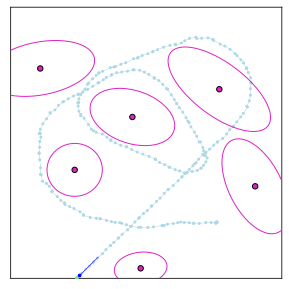

In [187]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["fast_slam_correction.txt"])

## Removing spurious landmarks

In [188]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/1lXD7nHDBxg" if "YouTube" in globals() else "//av.tib.eu/player/49037",
       width=560, height=315)

### Programming assignment: modify the previous code to remove spurious landmarks (10 Points).

In [189]:
# slam_10_f_counter
from lego_robot import *
from slam_g_library import get_cylinders_from_scan, write_cylinders,\
     write_error_ellipses, get_mean, get_error_ellipse_and_heading_variance,\
     print_particles
from math import sin, cos, pi
import copy
import random
import numpy as np

class Particle(Particle_5):
    def __init__(self, pose):
        super().__init__(pose)
        self.landmark_counters = []  # Added: counter for each landmark.

    # Solution from above, but modification is required.
    def update_particle(self, measurement, measurement_in_scanner_system,
                        number_of_landmarks,
                        minimum_correspondence_likelihood,
                        Qt_measurement_covariance, scanner_displacement):
        """Given a measurement, computes the likelihood that it belongs to any
           of the landmarks in the particle. If there are none, or if all
           likelihoods are below the minimum_correspondence_likelihood
           threshold, add a landmark to the particle. Otherwise, update the
           (existing) landmark with the largest likelihood."""
        # --->>> Copy & paste your code from above here.
        #        Then, modify as follows:
        #        - If a new landmark is initialized, append 1 to
        #          landmark_counters.
        #        - If an existing landmark is updated, add 2 to the
        #          corresponding landmark counter.

        # YOUR CODE HERE
        raise NotImplementedError()

    # New: Counter decrement for visible landmarks.
    def decrement_visible_landmark_counters(self, scanner_displacement):
        """Decrements the counter for every landmark which is potentially
           visible. This uses a simplified test: it is only checked if the
           bearing of the expected measurement is within the laser scanners
           range."""
        # Hints:
        # - We only check the bearing angle of the landmarks.
        # - Min and max bearing can be obtained from
        #   LegoLogfile.min_max_bearing()
        # - The bearing for any landmark can be computed using
        #   h_expected_measurement_for_landmark()
        # - If the bearing is within the range, decrement the corresponding
        #   self.landmark_counters[].

        # YOUR CODE HERE
        raise NotImplementedError()

    # New: Removal of landmarks with negative counter.
    def remove_spurious_landmarks(self):
        """Remove all landmarks which have a counter less than zero."""
        # Remove any landmark for which the landmark_counters[] is (strictly)
        # smaller than zero.
        # Note: deleting elements of a list while iterating over the list
        # will not work properly. One relatively simple and elegant solution is
        # to make a new list which contains all required elements.
        # (A compact way to do this is "list comprehensions with if clause",
        # but you may also use a for loop).
        # Remember to process landmark_positions, landmark_covariances and
        # landmark_counters.

        # YOUR CODE HERE
        raise NotImplementedError()

class FastSLAM(FastSLAM_2):
    # Modification of previous update_and_compute_weights() function.
    def update_and_compute_weights(self, cylinders):
        """Updates all particles and returns a list of their weights."""
        Qt_measurement_covariance = \
            np.diag([self.measurement_distance_stddev**2,
                     self.measurement_angle_stddev**2])
        weights = []
        for p in self.particles:
            # Added: decrement landmark counter for any visible landmark.
            p.decrement_visible_landmark_counters(self.scanner_displacement)

            # Loop over all measurements.
            number_of_landmarks = p.number_of_landmarks()
            weight = 1.0
            for measurement, measurement_in_scanner_system in cylinders:
                weight *= p.update_particle(
                    measurement, measurement_in_scanner_system,
                    number_of_landmarks,
                    self.minimum_correspondence_likelihood,
                    Qt_measurement_covariance, self.scanner_displacement)

            # Append overall weight of this particle to weight list.
            weights.append(weight)
            
            # Added: remove spurious landmarks (with negative counter).
            p.remove_spurious_landmarks()

        return weights


if __name__ == '__main__':
    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Cylinder extraction and matching constants.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # Filter constants.
    control_motion_factor = 0.35  # Error in motor control.
    control_turn_factor = 0.6  # Additional error due to slip when turning.
    measurement_distance_stddev = 200.0  # Distance measurement error of cylinders.
    measurement_angle_stddev = 15.0 / 180.0 * pi  # Angle measurement error.
    minimum_correspondence_likelihood = 0.001  # Min likelihood of correspondence.

    # Generate initial particles. Each particle is (x, y, theta).
    number_of_particles = 25
    start_state = np.array([500.0, 0.0, 45.0 / 180.0 * pi])
    initial_particles = [ Particle(start_state.copy())
                          for _ in range(number_of_particles)]

    # Setup filter.
    fs = FastSLAM(initial_particles,
                  robot_width, scanner_displacement,
                  control_motion_factor, control_turn_factor,
                  measurement_distance_stddev,
                  measurement_angle_stddev,
                  minimum_correspondence_likelihood)

    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")

    # Loop over all motor tick records.
    # This is the FastSLAM filter loop, with prediction and correction.
    f = open("fast_slam_counter.txt", "w")
    for i in range(len(logfile.motor_ticks)):
        # Prediction.
        control = [x * ticks_to_mm for x in logfile.motor_ticks[i]]
        fs.predict(control)

        # Correction.
        cylinders = get_cylinders_from_scan(logfile.scan_data[i], depth_jump,
            minimum_valid_distance, cylinder_offset)
        fs.correct(cylinders)

        # Output particles.
        print_particles(fs.particles, f)

        # Output state estimated from all particles.
        mean = get_mean(fs.particles)
        print("F %.0f %.0f %.3f" %\
              (mean[0] + scanner_displacement * cos(mean[2]),
               mean[1] + scanner_displacement * sin(mean[2]),
               mean[2]), file=f)

        # Output error ellipse and standard deviation of heading.
        errors = get_error_ellipse_and_heading_variance(fs.particles, mean)
        print("E %.3f %.0f %.0f %.3f" % errors, file=f)

        # Output landmarks of particle which is closest to the mean position.
        output_particle = min([
            (np.linalg.norm(mean[0:2] - fs.particles[i].pose[0:2]),i)
            for i in range(len(fs.particles)) ])[1]
        # Write estimates of landmarks.
        write_cylinders(f, "W C",
                        fs.particles[output_particle].landmark_positions)
        # Write covariance matrices.
        write_error_ellipses(f, "W E",
                             fs.particles[output_particle].landmark_covariances)

    f.close()

NotImplementedError: 

In [ ]:
# Execute this to run the interactive viewer.
import ipy_logfile_viewer as lfv
v = lfv.IPYLogfileViewer(files=["fast_slam_counter.txt"])

In [ ]:
from lego_robot import *
from slam_g_library import get_cylinders_from_scan, get_mean
from math import sin, cos, pi
import numpy as np
def generate_poses(the_particle_class, the_filter_class, n_particles):

    # Robot constants.
    scanner_displacement = 30.0
    ticks_to_mm = 0.349
    robot_width = 155.0

    # Cylinder extraction and matching constants.
    minimum_valid_distance = 20.0
    depth_jump = 100.0
    cylinder_offset = 90.0

    # Filter constants.
    control_motion_factor = 0.35
    control_turn_factor = 0.6
    measurement_distance_stddev = 200.0
    measurement_angle_stddev = 15.0 / 180.0 * pi
    minimum_correspondence_likelihood = 0.001

    # Generate initial particles. Each particle is (x, y, theta).
    number_of_particles = n_particles
    start_state = np.array([500.0, 0.0, 45.0 / 180.0 * pi])
    initial_particles = [ the_particle_class(start_state.copy())
                          for _ in range(number_of_particles)]
    # Setup filter.
    fs = the_filter_class(initial_particles,
                  robot_width, scanner_displacement,
                  control_motion_factor, control_turn_factor,
                  measurement_distance_stddev,
                  measurement_angle_stddev,
                  minimum_correspondence_likelihood)
    # Read data.
    logfile = LegoLogfile()
    logfile.read("robot4_motors.txt")
    logfile.read("robot4_scan.txt")
    # Loop over all motor tick records.
    poses = []
    for i in range(len(logfile.motor_ticks)):
        # Prediction.
        control = [x * ticks_to_mm for x in logfile.motor_ticks[i]]
        fs.predict(control)
        # Correction.
        cylinders = get_cylinders_from_scan(logfile.scan_data[i], depth_jump,
            minimum_valid_distance, cylinder_offset)
        fs.correct(cylinders)
        mean = get_mean(fs.particles)
        poses.append(mean)
    return poses

def test(the_particle_class, the_filter_class):
    ref_poses = np.array([
500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,
500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,500,0,0.785,
500,0,0.785,517,17,0.786,548,48,0.779,578,77,0.781,608,107,0.780,607,106,0.779,
637,135,0.773,668,165,0.770,698,194,0.770,725,221,0.773,723,219,0.770,
755,249,0.768,786,281,0.793,787,282,0.790,819,314,0.793,848,343,0.778,
878,373,0.770,909,402,0.778,940,431,0.791,940,432,0.787,973,462,0.774,
1003,492,0.782,1035,523,0.785,1034,522,0.783,1065,553,0.788,1096,584,0.785,
1127,614,0.786,1157,642,0.780,1156,638,0.775,1187,666,0.780,1217,694,0.782,
1247,722,0.772,1246,721,0.776,1278,751,0.762,1308,779,0.772,1338,806,0.770,
1369,835,0.777,1369,834,0.767,1400,860,0.752,1431,891,0.759,1459,920,0.762,
1459,919,0.761,1492,951,0.753,1523,978,0.737,1554,1008,0.732,1554,1007,0.726,
1584,1035,0.717,1616,1063,0.722,1644,1090,0.730,1676,1117,0.757,1676,1116,0.741,
1705,1147,0.852,1734,1183,0.956,1757,1219,1.044,1776,1259,1.151,1778,1258,1.146,
1793,1299,1.223,1804,1342,1.335,1809,1384,1.463,1813,1427,1.563,1815,1426,1.566,
1816,1467,1.747,1809,1506,1.930,1797,1542,2.069,1804,1545,2.002,1790,1580,2.096,
1778,1613,2.176,1756,1644,2.302,1757,1645,2.287,1729,1674,2.444,1699,1697,2.533,
1665,1715,2.668,1632,1731,2.793,1632,1728,2.794,1592,1740,2.947,1552,1747,3.060,
1514,1748,-3.083,1509,1746,-3.059,1467,1747,-3.024,1425,1742,-2.967,
1384,1731,-2.926,1345,1718,-2.890,1346,1712,-2.883,1306,1700,-2.880,
1264,1688,-2.875,1227,1679,-2.872,1186,1670,-2.873,1186,1671,-2.877,
1144,1660,-2.888,1105,1649,-2.892,1067,1637,-2.871,1064,1638,-2.880,
1021,1627,-2.878,982,1615,-2.880,942,1604,-2.886,906,1592,-2.871,
904,1592,-2.879,865,1582,-2.886,822,1571,-2.856,781,1561,-2.783,782,1562,-2.798,
745,1544,-2.638,711,1522,-2.506,682,1500,-2.429,682,1498,-2.409,655,1469,-2.271,
631,1438,-2.144,611,1408,-2.077,597,1377,-1.941,599,1375,-1.902,593,1339,-1.716,
594,1304,-1.569,598,1268,-1.402,600,1262,-1.368,612,1222,-1.181,630,1188,-1.044,
650,1159,-0.905,670,1136,-0.830,674,1135,-0.775,711,1107,-0.659,747,1084,-0.580,
784,1061,-0.518,788,1060,-0.516,829,1039,-0.504,869,1018,-0.489,909,999,-0.485,
910,998,-0.487,949,977,-0.480,988,956,-0.479,1027,934,-0.483,1068,913,-0.479,
1105,894,-0.474,1107,892,-0.479,1148,871,-0.484,1188,851,-0.475,1227,832,-0.458,
1225,832,-0.470,1265,812,-0.466,1297,794,-0.421,1329,783,-0.307,1352,776,-0.240,
1349,776,-0.216,1380,773,0.010,1411,774,0.207,1438,785,0.451,1436,785,0.471,
1461,803,0.693,1481,823,0.851,1496,845,0.999,1511,869,1.214,1508,867,1.253,
1516,899,1.510,1519,929,1.648,1514,969,1.747,1510,967,1.818,1496,1010,1.894,
1477,1048,1.970,1459,1084,2.006,1441,1119,2.017,1439,1122,2.016,1421,1161,2.018,
1403,1202,2.019,1384,1241,2.020,1366,1273,2.021,1366,1273,2.012,1348,1311,2.052,
1329,1348,2.089,1308,1385,2.178,1307,1385,2.190,1277,1422,2.281,1245,1455,2.369,
1215,1484,2.455,1217,1485,2.459,1181,1511,2.558,1144,1533,2.667,1107,1550,2.773,
1068,1563,2.900,1066,1564,2.918,1027,1570,3.049,991,1571,-3.133,953,1568,-3.053,
911,1560,-2.950,908,1558,-2.907,867,1544,-2.859,825,1529,-2.792,784,1511,-2.741,
783,1511,-2.729,745,1492,-2.720,703,1472,-2.717,666,1455,-2.710,627,1438,-2.718,
625,1438,-2.719,588,1419,-2.717,550,1403,-2.686,512,1383,-2.657,513,1381,-2.649,
475,1359,-2.559,439,1332,-2.470,407,1305,-2.428,407,1305,-2.429,373,1276,-2.286,
346,1241,-2.154,323,1206,-2.046,305,1171,-1.954,304,1170,-1.949,289,1126,-1.882,
276,1084,-1.837,268,1039,-1.718,261,994,-1.674,260,988,-1.673,256,939,-1.578,
258,892,-1.499,261,848,-1.420,266,844,-1.404,276,796,-1.314,290,750,-1.205,
309,708,-1.096,328,673,-1.033,329,671,-1.032,356,633,-0.933,384,600,-0.866,
414,567,-0.795,414,568,-0.784,446,539,-0.694,482,513,-0.597,516,491,-0.539,
553,472,-0.473,554,472,-0.455,595,455,-0.371,641,441,-0.321,684,429,-0.303,
687,430,-0.303,730,417,-0.306,773,404,-0.308,817,391,-0.310,857,378,-0.295,
856,377,-0.304,899,363,-0.258,941,354,-0.214,980,345,-0.150,979,345,-0.142,
1024,341,-0.036,1069,340,0.028,1110,345,0.074,1152,349,0.091,1150,349,0.090,
1196,353,0.086,1239,356,0.095,1282,361,0.102,1284,358,0.091,1329,362,0.088,
1372,365,0.092,1414,369,0.087,1415,369,0.094,1461,373,0.083,1505,376,0.089,
1545,380,0.098,1585,386,0.106,1591,384,0.098,1592,383,0.085,1594,382,0.077,
1595,382,0.075,1595,382,0.073,1595,382,0.072,1595,382,0.072,1594,382,0.071,])
    ref_poses = ref_poses.reshape(ref_poses.shape[0]//3,3)

    for experiment in range(10):
        # Generate poses.
        poses = np.array(generate_poses(the_particle_class,
                                        the_filter_class, 25))
        # Compare.
        diff = ref_poses-poses
        diff[:,2] = (diff[:,2] + np.pi) % (2*np.pi) - np.pi
        d = np.max(np.abs(diff), axis=0)

        # Quit if close.
        if (d < (150, 150, 0.3)).all():
            return True
    return False
assert test(Particle, FastSLAM), "Oh no, it's wrong!"

## Conclusions and final remarks

In [ ]:
# If you don't see a video below, run this cell.
IFrame("https://www.youtube.com/embed/gwxBrE-aYmc" if "YouTube" in globals() else "//av.tib.eu/player/49038",
       width=560, height=315)